./results_MNIST/2nn_nll_H22_bias10_schedulerTrue_decrease_50_epoch_factor_0.1.pkl
15
./results_MNIST/parallel_nll_H20_M3_bias10_range20_lr_thres0.01_lr_ampli0.001_lr_slope0.001_lr_scaler0.001_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl
14


Text(0, 0.5, 'Accuracy')

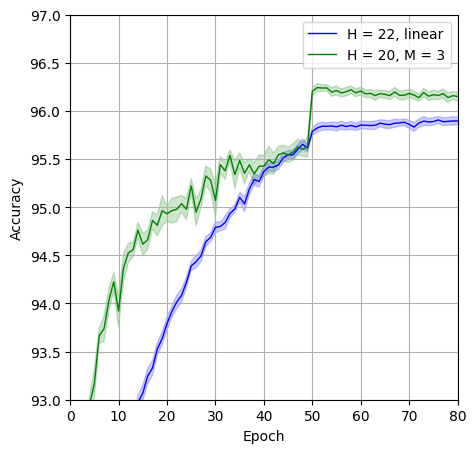

In [1]:
from training import *
from analysis import *
from network import *
files = [
    # './results_MNIST/2nn_nll_H20_bias20_schedulerTrue_decrease_50_epoch_factor_0.1.pkl',
    
    # './results_MNIST/parallel_nll_H20_M1_bias20_range50_lr_thres0.1_lr_ampli0.001_lr_slope0.001_lr_scaler0.05_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl',
    
    './results_MNIST/2nn_nll_H22_bias10_schedulerTrue_decrease_50_epoch_factor_0.1.pkl',
    './results_MNIST/parallel_nll_H20_M3_bias10_range20_lr_thres0.01_lr_ampli0.001_lr_slope0.001_lr_scaler0.001_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl',
    # './results_MNIST/parallel_nll_H20_M5_bias10_range20_lr_thres0.01_lr_ampli0.001_lr_slope0.001_lr_scaler0.001_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl',
    # './results_MNIST/parallel_nll_H20_M10_bias20_range50_lr_thres0.1_lr_ampli0.001_lr_slope0.001_lr_scaler0.05_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl'
    
]
labels = [   'H = 22, linear', 'H = 20, M = 3', 'H = 20, M = 5', 'H = 20, M = 10']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(5,5))
for i, file in enumerate(files):
    with open(file, 'rb') as f:
        results1 = pickle.load(f) 
    print(file)
    print(len(results1))
    acc1 = get_acc(results1)
    plt.plot(acc1.mean(axis=0), label= labels[i], linestyle='-', linewidth = 1,color=colors[i])
    plt.fill_between(np.arange(acc1.shape[1]), 
            acc1.mean(axis = 0) - acc1.std(axis = 0)/np.sqrt(len(results1)), 
            acc1.mean(axis = 0) + acc1.std(axis = 0)/np.sqrt(len(results1)), alpha = 0.2, color=colors[i])
plt.legend()
plt.xlim([0, 80])
plt.ylim([93, 97])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [2]:
from scipy.interpolate import interp1d
def plot_hidden_actv_(model, 
                    testloader, 
                    hidden_act:str = 'relu', 
                    is_normalized = False,
                    file_name = '',
                    is_scaler = True,
                    is_sign = False) -> None:
    '''
    plot histograms of hidden layer input and final layer input 
    with histogram normalization
    
    also plot learned aggregate synaptic function for each hidden-output connection
    grouped by output unit
    
    Inputs:
        model: nn.Module
        testloader: torch.utils.data.DataLoader
        
        hidden_act: str, 'sigmoid' or 'relu', default: 'relu'
        is_normalized: bool, whether to normalize input histogram
        file_name: str, file name to save figure
        is_scaler: bool, whether to multiply aggregate synaptic function with the magnitude of scaler, |c_{i,k}|
        is_sign: bool, whether to multiply aggregate synaptic function with the sign of scaler, sgn(c_{i,k})
    '''
    
    # collection hidden layer input from test dataset
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
        elif hidden_act == 'relu':
            hidden.append(torch.relu(model.bn1 ( model.fc1(inputs) )+2 ).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
        
    hidden_thres = 0 # if hidden unit input is too small and close to zero, we ignore it
    hidden = torch.cat(hidden, dim=0)
    hidden = hidden.data.cpu().numpy() # n_data x n_hidden
    final = torch.cat(final, dim=0)
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    
    hidden_list = [] 
    input_list = []
    for i in np.arange(hidden.shape[1]):
        tmp_hidden = hidden[:, i].ravel()
        
        tmp_hidden = tmp_hidden[tmp_hidden > hidden_thres]
        
        min_val =-1# min(tmp_hidden.min(), model.parallel_synapse.thres[:, i,:].detach().numpy().min()-1)
        max_val = max(tmp_hidden.max(), model.parallel_synapse.thres[:, i,:].detach().numpy().max()+1)
        input_list.append(np.linspace(min_val, max_val, n_data))
        hidden_list.append(tmp_hidden)
    
    input = torch.cat([torch.tensor(input_list[i]).reshape(-1, 1) for i in np.arange(hidden.shape[1])], dim = 1)
    
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    
    # aggregate synaptic function
    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * (input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
        - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim))
    x = torch.tanh(x)
    x = x * (ampli[None, :, :, :]**2 ).expand(n_data, n_synapse, input_dim, output_dim)
    if is_scaler and is_sign:
        x = x.detach().numpy() * f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim).detach().numpy()
    elif is_scaler and not is_sign:
        x = x.detach().numpy() * np.abs(f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim).detach().numpy())
    elif not is_scaler and not is_sign:
        x = x.detach().numpy()
    x = x.sum(axis=1).squeeze() # shape: n_data x input_dim x output_dim
    
    fig, axs = plt.subplots(4,5, figsize = (15, 10))
    for i in range(20):
        # hidden unit activation histogram 
        ax1 = axs.flatten()[i]
        ax1.hist(hidden_list[i], bins=input[:,i], density=True, alpha=0.75)
        ax1.set_title(f'Hidden unit {i+1}')
        # ax1.set_xlabel('Activation')
        # ax1.set_ylabel('Density')
        
        ax2 = axs.flatten()[i].twinx()
        
        ax2.plot(input[:,i], x[:, i, :], linewidth = 2)
        # plot the range of input
        ax2.plot([input[0, i], input[0, i]], [x[:, i, :].min(), x[:, i, :].max()], 'r--', label = 'min/max input')
        
        ax2.plot([hidden_list[i].max(), hidden_list[i].max()], [x[:, i, :].min(), x[:, i, :].max()], 'r--')
        mean, std = hidden_list[i].mean(), hidden_list[i].std()
        minval, maxval = max(0,mean-std), mean+std
        ax2.plot([minval, minval], [x[:, i, :].min(), x[:, i, :].max()], 'g--', label = 'mean +/- std') 
        
        ax2.plot([maxval, maxval], [x[:, i, :].min(), x[:, i, :].max()], 'g--')
        minval, maxval = max(0,mean-2.5*std), mean+2.5*std
        ax2.plot([minval, minval], [x[:, i, :].min(), x[:, i, :].max()], 'y--', label = 'mean +/- 2*std') 
        
        ax2.plot([maxval, maxval], [x[:, i, :].min(), x[:, i, :].max()], 'y--')
        
        minval, maxval = max(0,mean-3.*std), mean+3.*std
        ax1.set_xlim([minval, maxval])
        # ax2.set_ylabel('Synaptic function')
    # plt.legend()
    plt.tight_layout() 
    plt.show()
    

./results_MNIST/parallel_nll_H20_M3_bias10_range20_lr_thres0.01_lr_ampli0.001_lr_slope0.001_lr_scaler0.001_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl


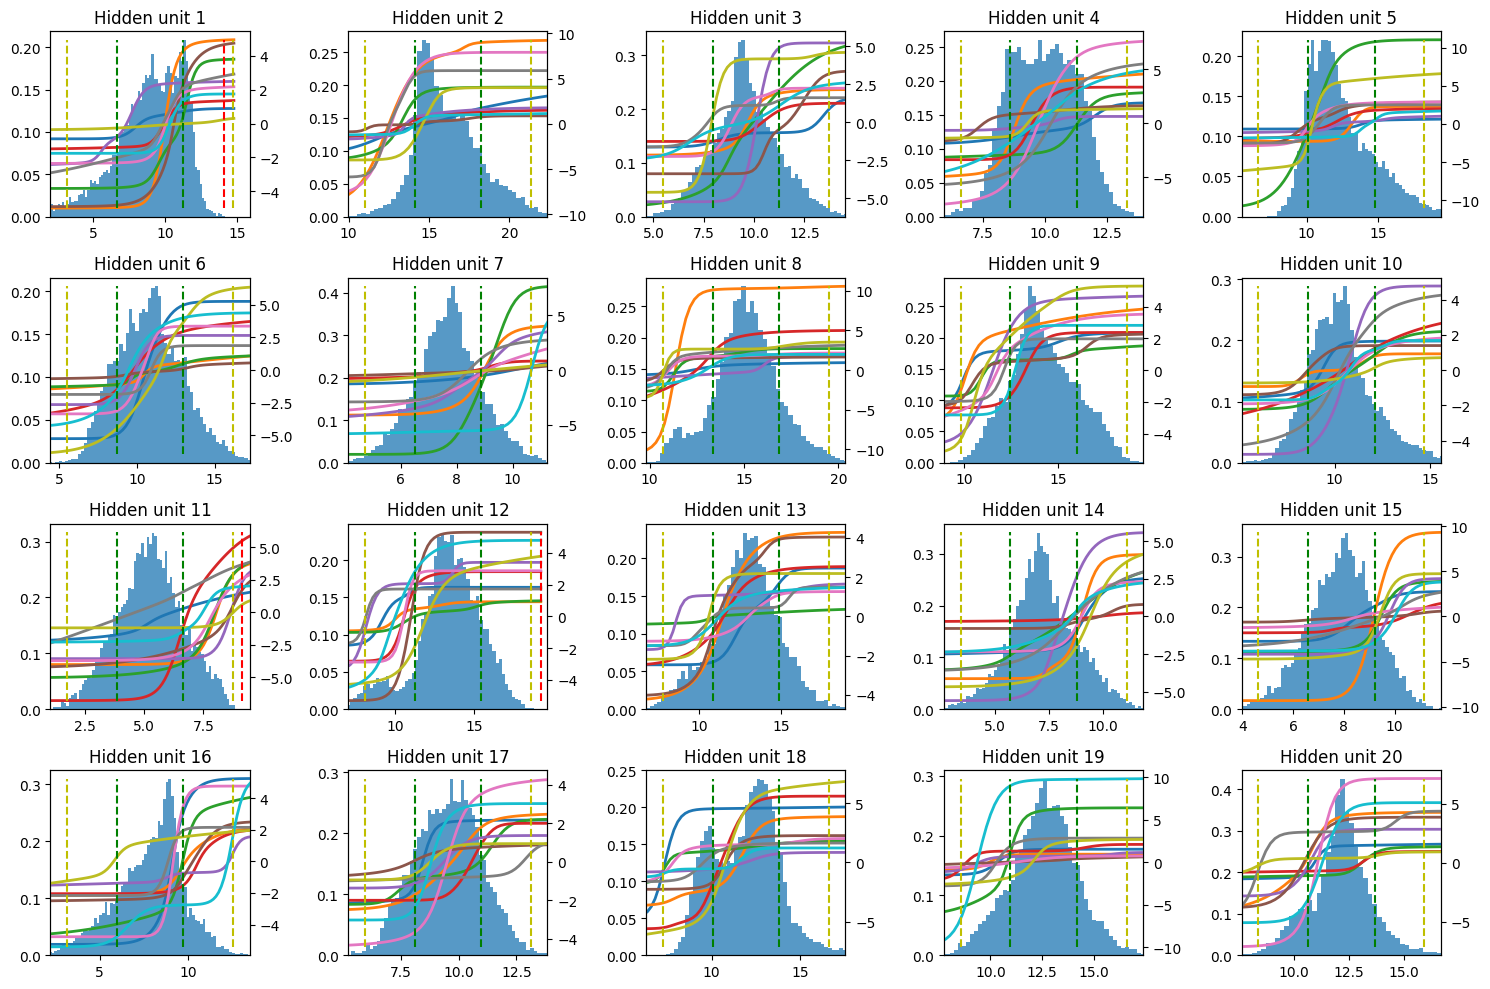

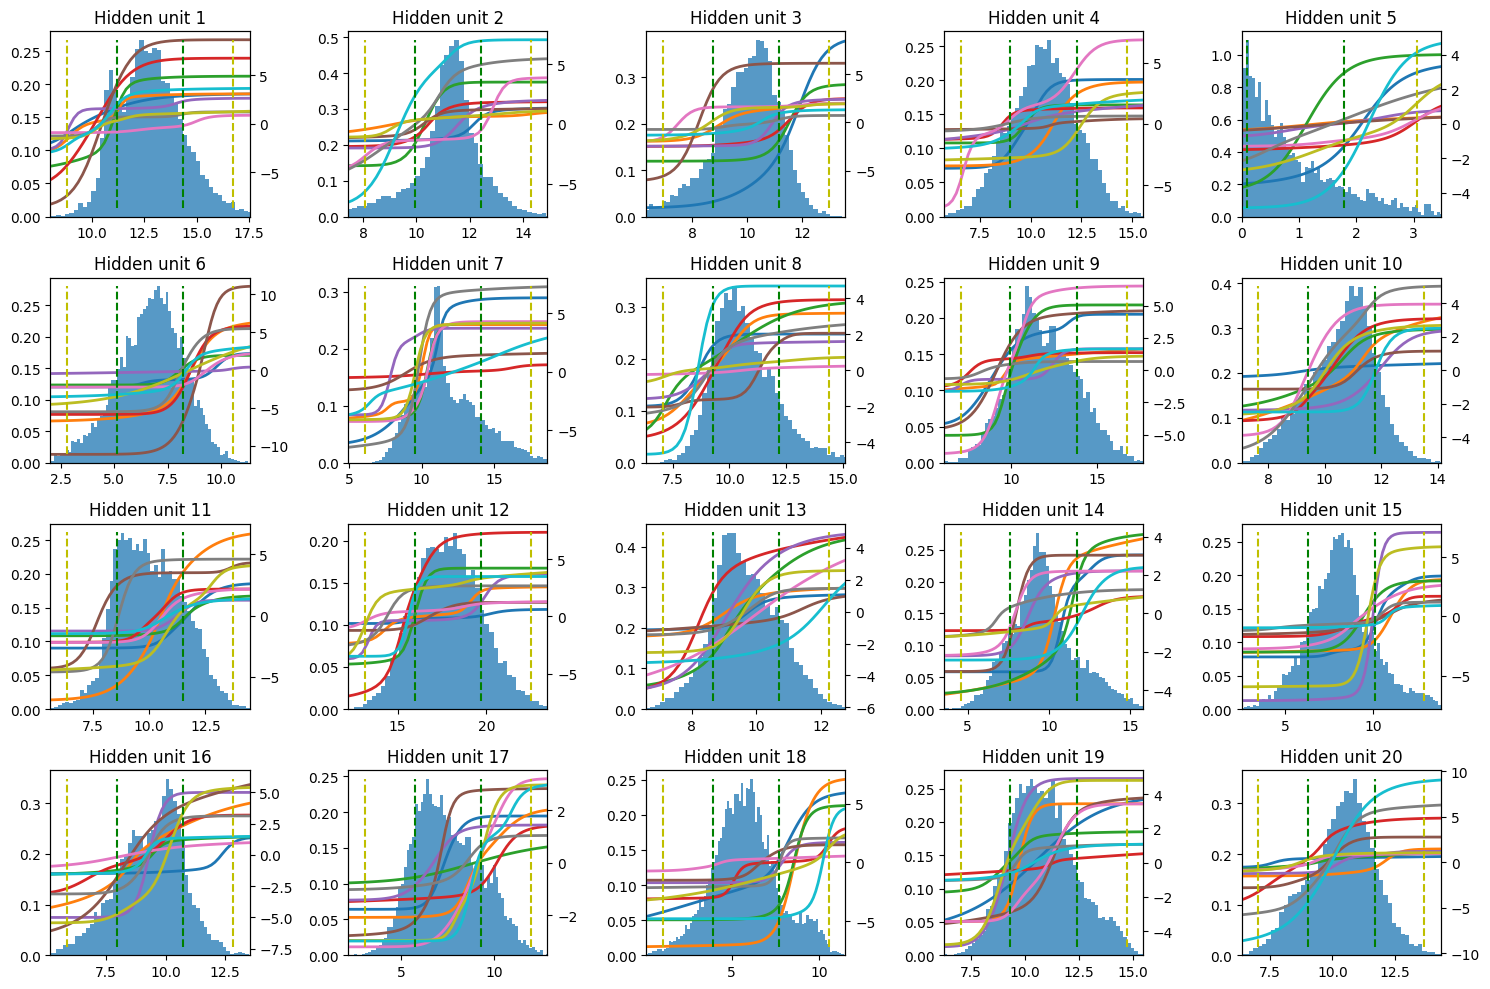

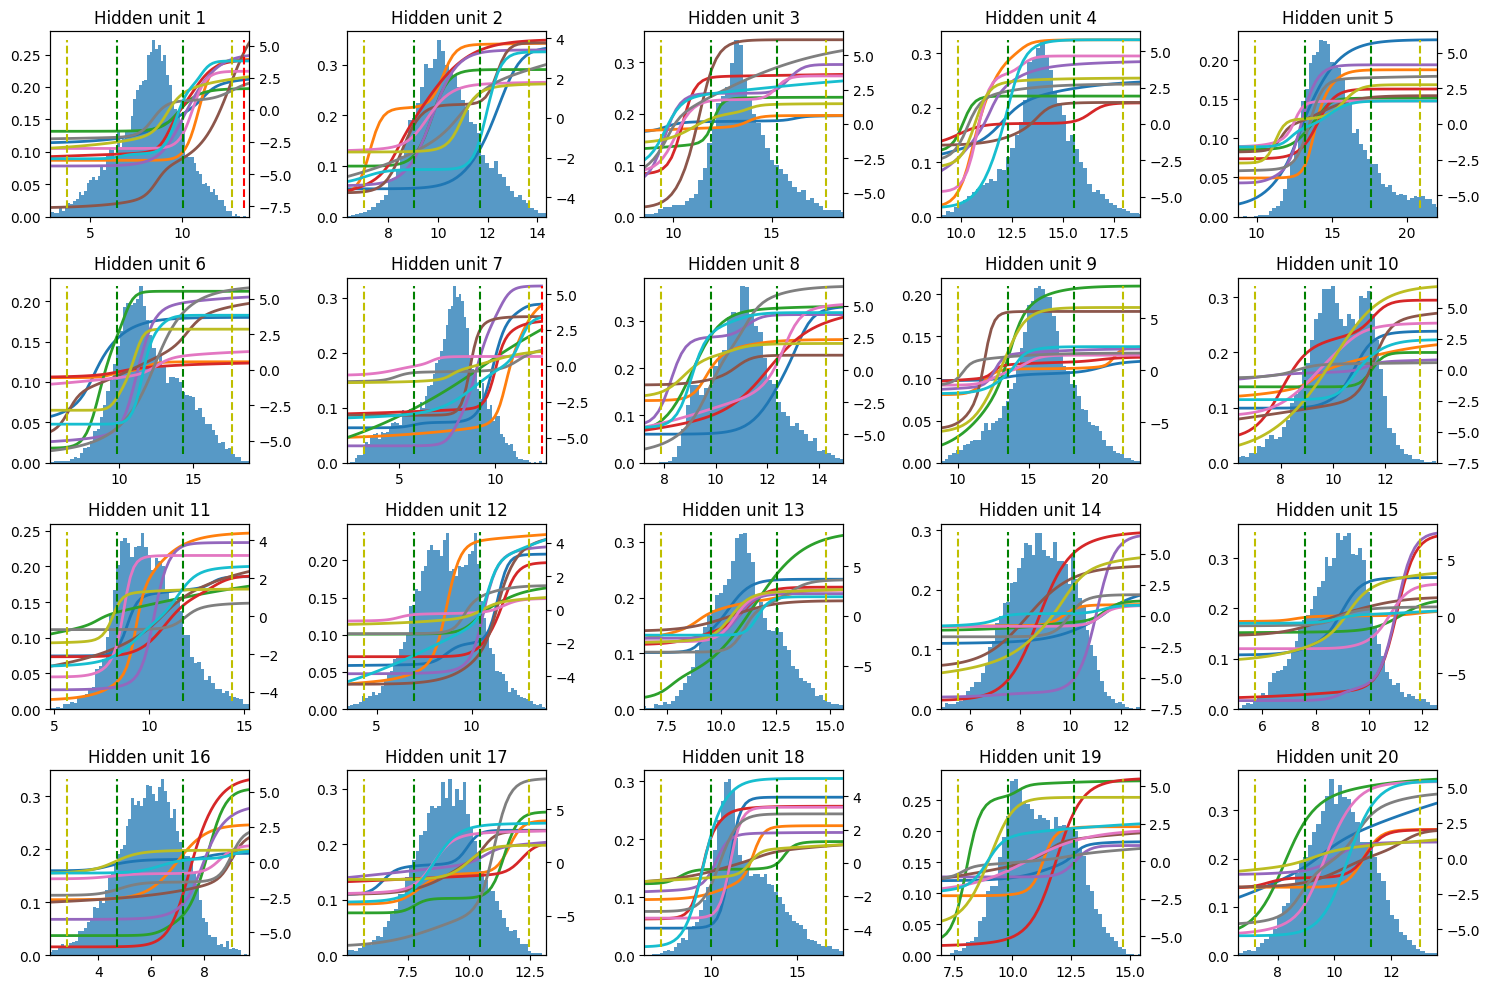

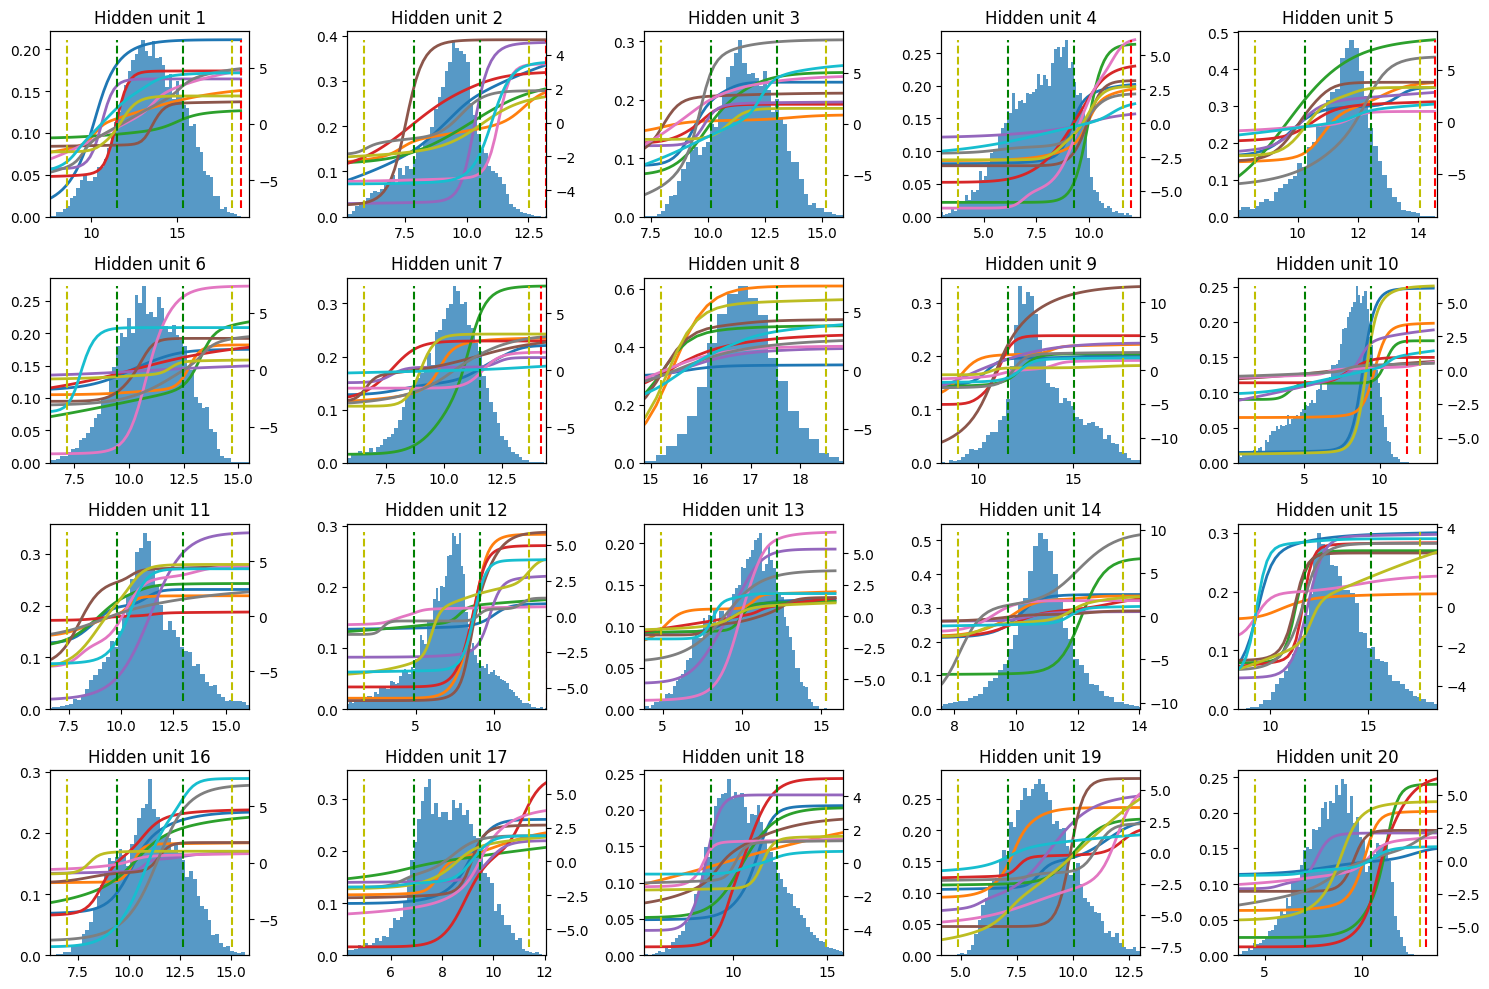

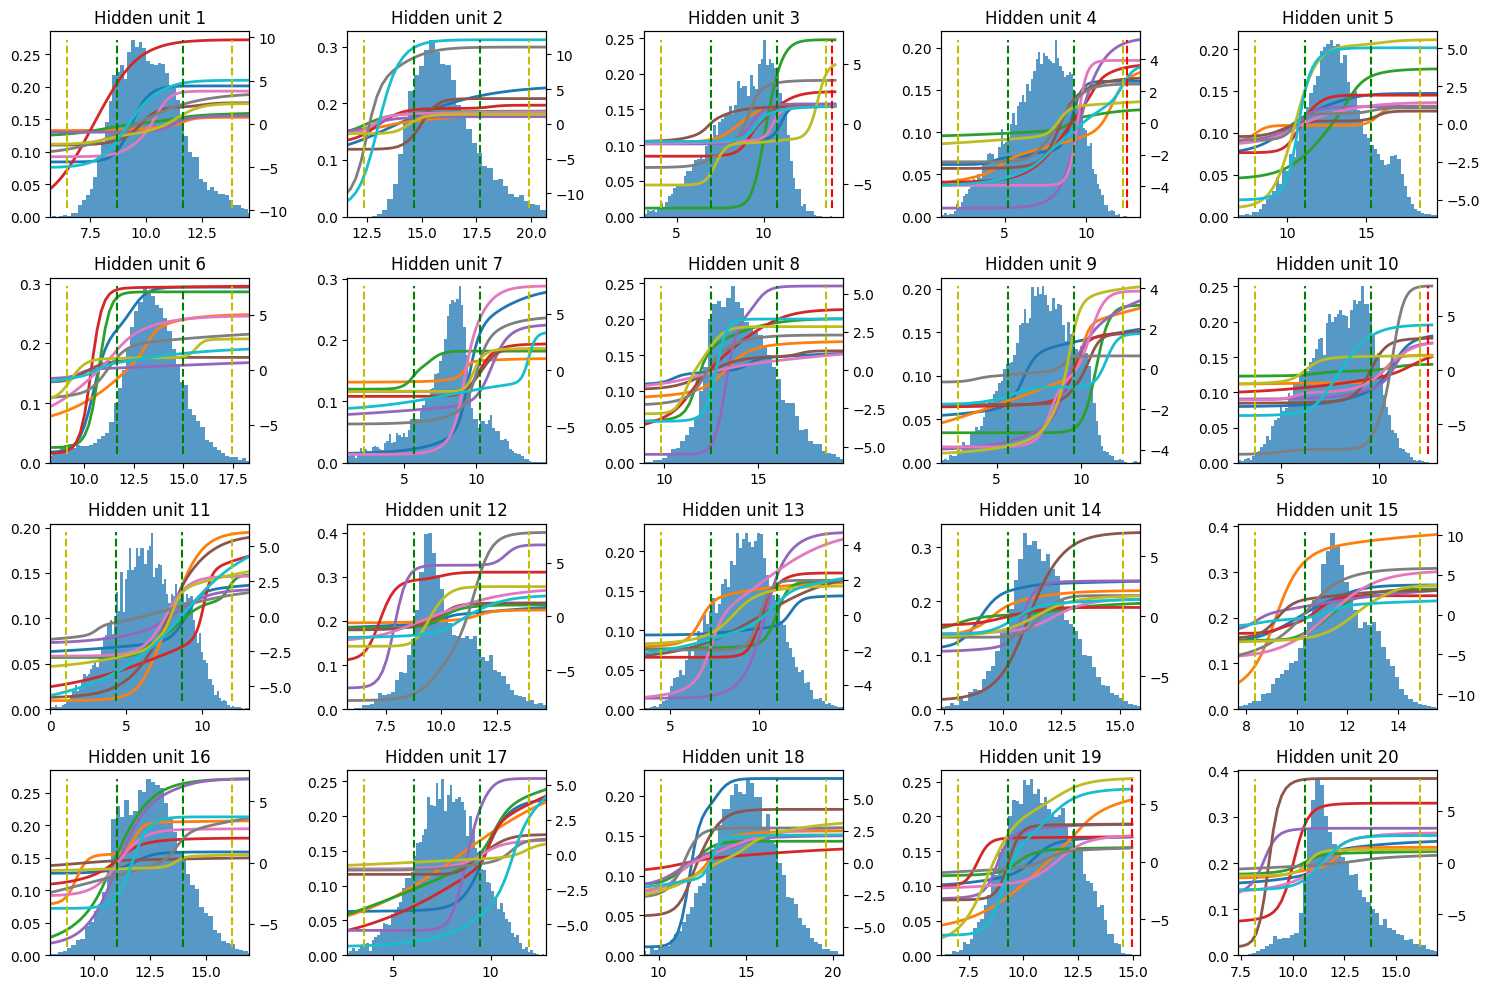

In [162]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

parallel_syn_files = [
    # './results_MNIST/parallel_nll_H20_M1_bias20_range50_lr_thres0.1_lr_ampli0.001_lr_slope0.001_lr_scaler0.05_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl',
    './results_MNIST/parallel_nll_H20_M3_bias10_range20_lr_thres0.01_lr_ampli0.001_lr_slope0.001_lr_scaler0.001_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl',
    # './results_MNIST/parallel_nll_H20_M5_bias20_range50_lr_thres0.1_lr_ampli0.001_lr_slope0.001_lr_scaler0.05_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl',
    # './results_MNIST/parallel_nll_H20_M10_bias20_range50_lr_thres0.1_lr_ampli0.001_lr_slope0.001_lr_scaler0.05_lr0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v4.pkl'
    ]

for i, file in enumerate(parallel_syn_files):
    print(file)
    with open(file, 'rb') as f:
        results1 = pickle.load(f)
    for r in results1[:5]:
        model = r['model']
        plot_hidden_actv_(model, testloader, hidden_act='relu', is_sign=False, is_scaler=True)
    

In [3]:
# visualize the distribution of amplitude and slope

def plot_synaptic_distribution(model):
        slope = model.parallel_synapse.slope.detach().numpy().ravel()
        ampli = model.parallel_synapse.ampli.detach().numpy().ravel()
        thres = model.parallel_synapse.thres.detach().numpy().ravel()
        scaler = model.parallel_synapse.scaler.detach().numpy().ravel() 
        plt.figure( figsize = (12,3))
        plt.subplot(1,4,1)
        plt.hist(slope, bins=30, label = f'slope, M = {model.parallel_synapse.slope.shape[0]}')
        
        plt.subplot(1,4,2)
        plt.hist(ampli**2, bins=30, label = f'amplitude, M = {model.parallel_synapse.slope.shape[0]}')
        plt.subplot(1,4,3)
        plt.hist(thres, bins=30, label = f'threshold, M = {model.parallel_synapse.slope.shape[0]}')
        plt.subplot(1,4,4)
        plt.hist(scaler, bins=30, label = f'scaler, M = {model.parallel_synapse.slope.shape[0]}')
        plt.subplot(1,4,1)
        # plt.legend()
        plt.title('Slope' + f'({np.sum(slope < 0.1)/len(slope):.2f})')
        plt.subplot(1,4,2)
        # plt.legend()
        # show the propostional of amplitude less than 0.2
        plt.title('Amplitude' + f'({np.sum(ampli**2 < 0.1)/len(ampli):.2f})')
        plt.subplot(1,4,3)
        # plt.legend()
        plt.title('Threshold' + f'({np.sum(thres < 0.1)/len(thres):.2f})')
        plt.subplot(1,4,4)
        # plt.legend()
        plt.title('Scaler' + f'({np.sum(scaler < 0.1)/len(scaler):.2f})')
        plt.show()

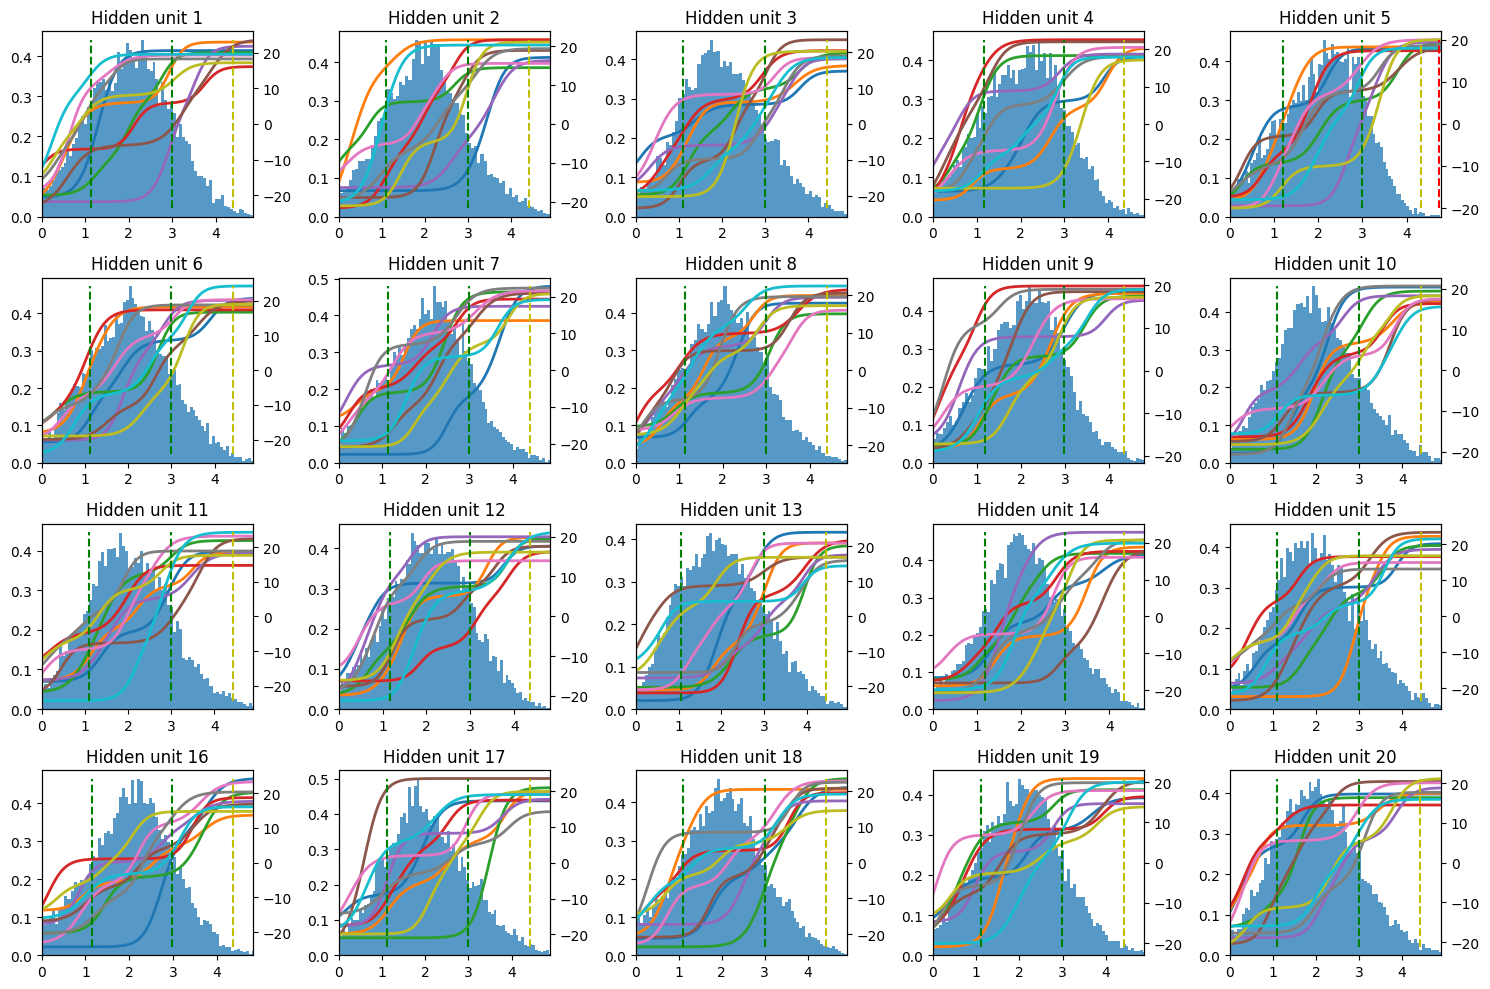

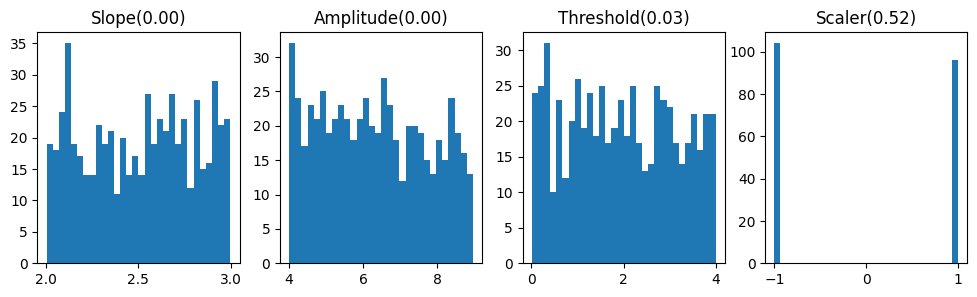

       Epoch 1/10, Loss: 4.6105, Accuracy: 88.88%
        Elapsed time: 0:00:04.956576


In [4]:
input_dim = 28*28
hidden_dim = 20
n_synapse = 3
hidden_range = (0,4)
bias = 10
dataset = 'MNIST'
model_type = 'parallel'
loss_type = 'nll'
use_scheduler = True
lr = 0.001
lr_ampli = 0.001
lr_slope = 0.001
lr_thres = 1e-4
lr_scaler = 0.0005
decrease_epoch = 100
decrease_factor = 0.1

model = ParallelSynapse2NN(input_dim=input_dim,
        hidden_dim = hidden_dim, 
        n_synapse = n_synapse,
        hidden_range = hidden_range, 
        additive_bias = bias)
model.parallel_synapse.slope.data *= 3
train_loader, test_loader = get_loader(dataset)

for i in range(20):
    plot_hidden_actv_(model, test_loader, hidden_act='relu', is_sign=False, is_scaler=True)
    plot_synaptic_distribution(model)
    result = train_models(model, 
                input_dim,
                train_loader,
                test_loader,
                num_epochs=10,
                model_type=model_type,
                loss_type=loss_type,
                use_scheduler=use_scheduler,
                lr = lr,
                lr_ampli=lr_ampli,
                lr_slope=lr_slope,
                lr_thres=lr_thres,
                lr_scaler = lr_scaler,
                decrease_epoch = decrease_epoch, 
                decrease_factor = decrease_factor)
    
    